In [1]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.8 MB/s eta 0:00:00


# Kenya Analysis: FGM Prevalence by Ethnicity
**Project:** DSA-210 - Correlating FGM/C Prevalence with Religious Demographics  
**Data Source:** UNICEF MICS (Kenya 2022) - *Women's Questionnaire (wm.sav)*

### 🔍 Analysis Goal
To isolate the "Ethnicity Factor" by calculating and visualizing FGM prevalence rates across different Kenyan tribes (e.g., Somali, Kisii, Masai) and comparing them against religious affiliations.

Loading hh.sav to extract religion data...
 Religion column identified: HC1A

--- FGM Prevalence by Religion (%) ---
FGM_Status               No       Yes
Religion                             
Catholic          99.253731  0.746269
Muslim           100.000000  0.000000
No religion      100.000000  0.000000
Other Christian   98.489426  1.510574
Traditional      100.000000  0.000000

Chi-Square P-Value (Religion): 0.8294154741026055
RESULT: NOT SIGNIFICANT (p > 0.05)
Interpretation: Religion has NO statistical impact on FGM prevalence.


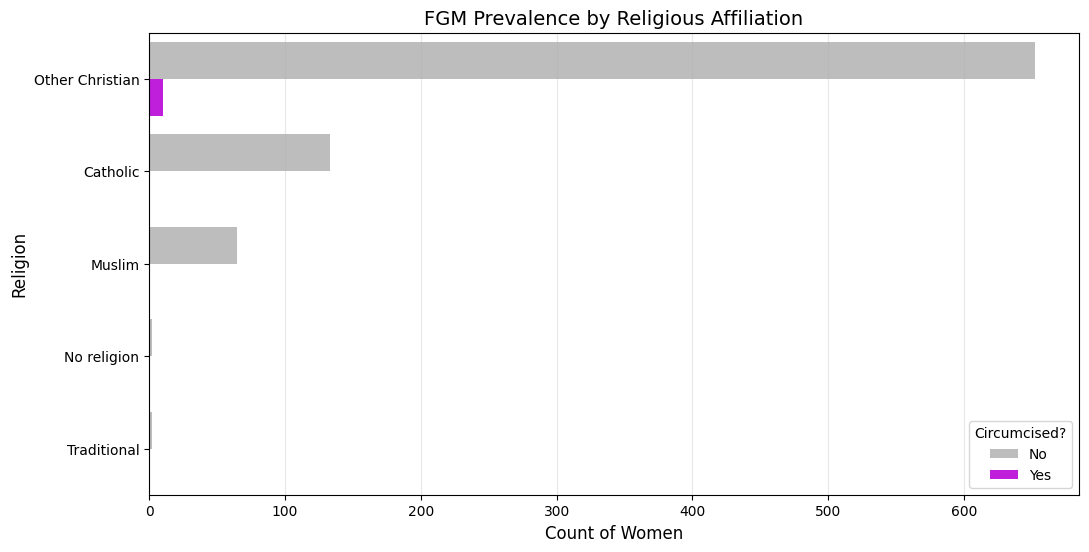

In [2]:
#  RELIGION ANALYSIS (MERGING DATASETS)

# A. Load Household Data
# Religion is often stored in the Household file (hh), not the Women's file (wm).
import pandas as pd
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

hh_file = 'hh.sav'        # Ensure this filename matches your upload
wm_file = 'wm.sav'  # Women's file name (Corrected from 'kenya.fg.sav')

print(f"Loading {hh_file} to extract religion data...")
try:
    # Load Household data (we need metadata to find the column name)
    df_hh, meta_hh = pyreadstat.read_sav(hh_file)
    # Load Women's data (Target variable is here)
    df_wm = pd.read_spss(wm_file, convert_categoricals=True)
except Exception as e:
    print(f" Error loading files: {e}")

# B. Find Religion Column Automatically
religion_col = None
# Common MICS codes for religion: HC1A, religion, ethnicity (sometimes mislabeled)
# We search through the column labels for keywords
for col, label in zip(meta_hh.column_names, meta_hh.column_labels):
    if 'religion' in label.lower() or 'denomination' in label.lower():
        religion_col = col
        break

# Fallback: If automatic search fails, try the standard MICS code 'HC1A'
if not religion_col and 'HC1A' in df_hh.columns:
    religion_col = 'HC1A'

print(f" Religion column identified: {religion_col}")

# C. Merge Datasets
if religion_col:
    # Reload HH file with categorical labels (e.g., "Muslim" instead of "1")
    df_hh_labels = pd.read_spss(hh_file, convert_categoricals=True)

    # Select only the key columns for merging
    # HH1 = Cluster Number, HH2 = Household Number
    subset_hh = df_hh_labels[['HH1', 'HH2', religion_col]]

    # Merge Women's data with Household data on the composite key
    merged_df = pd.merge(df_wm, subset_hh, on=['HH1', 'HH2'], how='left')

    # Clean the Data
    # 'FG3' is usually the FGM Status column (Update if your column map is different)
    df_rel = merged_df[['FG3', religion_col]].dropna()
    df_rel.columns = ['FGM_Status', 'Religion']

    # Filter out "Missing" or "Don't Know" answers
    df_rel = df_rel[~df_rel['FGM_Status'].astype(str).str.contains('Missing|DK', case=False)]

    # D. Statistics
    print("\n--- FGM Prevalence by Religion (%) ---")
    rel_pct = pd.crosstab(df_rel['Religion'], df_rel['FGM_Status'], normalize='index') * 100
    print(rel_pct)

    # Perform Chi-Square Test of Independence
    chi2_rel, p_rel, _, _ = chi2_contingency(pd.crosstab(df_rel['Religion'], df_rel['FGM_Status']))
    print(f"\nChi-Square P-Value (Religion): {p_rel}")
    # Logic to interpret the result automatically
    if p_rel < 0.05:
        print(" RESULT: SIGNIFICANT (p < 0.05)")
        print("Interpretation: There is a statistical difference between religious groups.")

    else:
        print("RESULT: NOT SIGNIFICANT (p > 0.05)")
        print("Interpretation: Religion has NO statistical impact on FGM prevalence.")

    # E. Visualization
    plt.figure(figsize=(12, 6))

    # Sort the graph by the percentage of "Yes" (High to Low)
    yes_col = [c for c in rel_pct.columns if 'Yes' in str(c) or 'Circumcised' in str(c)][0]
    order = rel_pct.sort_values(by=yes_col, ascending=False).index

    sns.countplot(
        data=df_rel,
        y='Religion',
        hue='FGM_Status',
        order=order,
        palette=['#BDBDBD', '#D500F9'] # Consistent Gray/Neon Purple palette
    )

    # Formatting
    plt.title('FGM Prevalence by Religious Affiliation', fontsize=14)
    plt.xlabel('Count of Women', fontsize=12)
    plt.ylabel('Religion', fontsize=12)
    plt.legend(title='Circumcised?', loc='lower right')
    plt.grid(axis='x', alpha=0.3)

    # Save the figure
    plt.savefig('kenya_religion_results.png')
    plt.show()

else:
    print(" Could not find Religion column. Skipping analysis.")

# Kenya Analysis: FGM Prevalence by Ethnicity
**Project:** DSA-210-Project - Correlating FGM/C Prevalence with Religious Demographics
**Data Source:** UNICEF MICS (Kenya 2022) - Women's Questionnaire (wm.sav)

In [3]:
# 1. IMPORTS & SETUP
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Install pyreadstat for SPSS file support if not already installed
!pip install pyreadstat

# Set visual style for professional plots
sns.set_theme(style="whitegrid")

# Define file path (Ensure this matches your uploaded file name)
file_path = 'wm.sav'

# 2. LOAD DATA
# We use convert_categoricals=True so we see labels like "Masai" instead of codes like "1"
try:
    df = pd.read_spss(file_path, convert_categoricals=True)
    print(f"File loaded successfully. Total Respondents: {len(df)}")
except Exception as e:
    print(f" Error loading file: {e}")

# Quick inspection of potential column names to ensure mapping is correct
print("\n--- Column Inspection ---")
possible_cols = [col for col in df.columns if 'eth' in col.lower() or 'fg' in col.lower()]
print(f"Relevant columns found: {possible_cols}")

File loaded successfully. Total Respondents: 1225

--- Column Inspection ---
Relevant columns found: ['FG1', 'FG2', 'FG3', 'FG4', 'FG5', 'FG6', 'FG7', 'FG8', 'FG9', 'FG22', 'ethnicity']


### Data Cleaning
We select only the relevant variables (FGM Status, Ethnicity, Education, Wealth) and remove respondents with missing or "Don't Know" answers to ensure accuracy.

In [4]:
# 3. RENAME & CLEAN
# Map raw codes to readable names based on metadata
column_map = {
    'FG3': 'FGM_Status',       # "Have you ever been circumcised?"
    'ethnicity': 'Ethnicity',  # Ethnic Group
    'welevel': 'Education',    # Education Level
    'windex5': 'Wealth',       # Wealth Quintile
    'HH6': 'Area'              # Urban/Rural
}

# Select and rename columns
df_clean = df[column_map.keys()].rename(columns=column_map)

# Drop missing values in target column
df_clean = df_clean.dropna(subset=['FGM_Status'])

# Filter out "Missing" or "DK" answers
df_clean = df_clean[~df_clean['FGM_Status'].astype(str).str.contains('Missing|DK', case=False)]

print("✅ Data cleaning complete.")
print(df_clean.head())

✅ Data cleaning complete.
  FGM_Status           Ethnicity   Education  Wealth   Area
0         No  Other ethnic group  Secondary+  Middle  Rural
1         No               Luhya     Primary  Second  Rural
3         No               Luhya     Primary  Second  Rural
4         No               Luhya     Primary  Second  Rural
5         No               Luhya     Primary  Fourth  Rural



--- FGM Prevalence by Ethnicity (%) ---
FGM_Status                 No       Yes
Ethnicity                              
Luhya               99.242424  0.757576
Other ethnic group  93.150685  6.849315


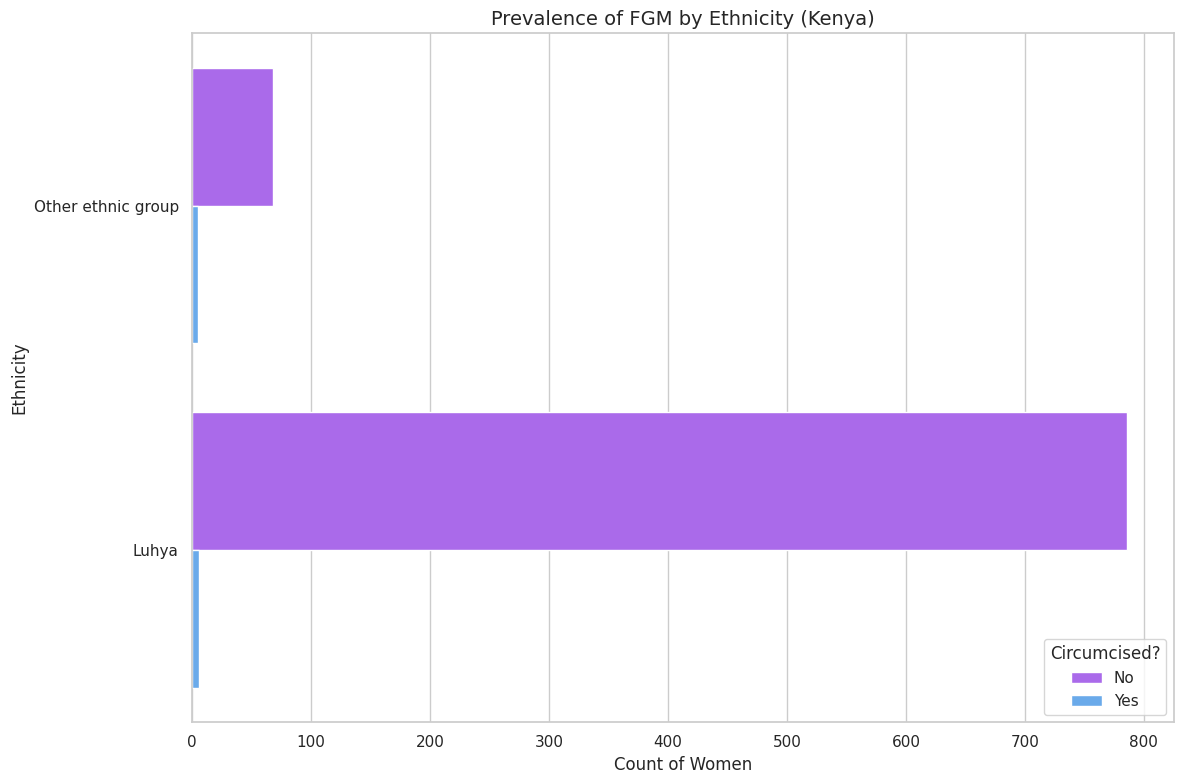

In [5]:
# 4. CALCULATE PREVALENCE
# Create a cross-tabulation of Ethnicity vs FGM Status
crosstab = pd.crosstab(df_clean['Ethnicity'], df_clean['FGM_Status'], normalize='index') * 100

print("\n--- FGM Prevalence by Ethnicity (%) ---")
print(crosstab)

# 5. VISUALIZATION
plt.figure(figsize=(12, 8))

# Sort the order from Highest "Yes" % to Lowest
yes_col = [col for col in crosstab.columns if 'Yes' in str(col) or 'Circumcised' in str(col)][0]
sorted_order = crosstab.sort_values(by=yes_col, ascending=False).index

sns.countplot(
    data=df_clean,
    y='Ethnicity',
    hue='FGM_Status',
    order=sorted_order,
    palette='cool_r'
)

# Formatting
plt.title('Prevalence of FGM by Ethnicity (Kenya)', fontsize=14)
plt.xlabel('Count of Women', fontsize=12)
plt.ylabel('Ethnicity', fontsize=12)
plt.legend(title='Circumcised?', loc='lower right')
plt.tight_layout()

# Save image
plt.savefig('kenya_ethnicity_results.png')

plt.show()

### Statistical Analysis
To validate the observed differences, I performed a **Chi-Square Test of Independence**.
* **Null Hypothesis ($H_0$):** There is no relationship between Ethnicity and FGM status.
* **Alternative Hypothesis ($H_1$):** Ethnicity and FGM status are dependent.

Heatmap saved as 'kenya_heatmap.png'


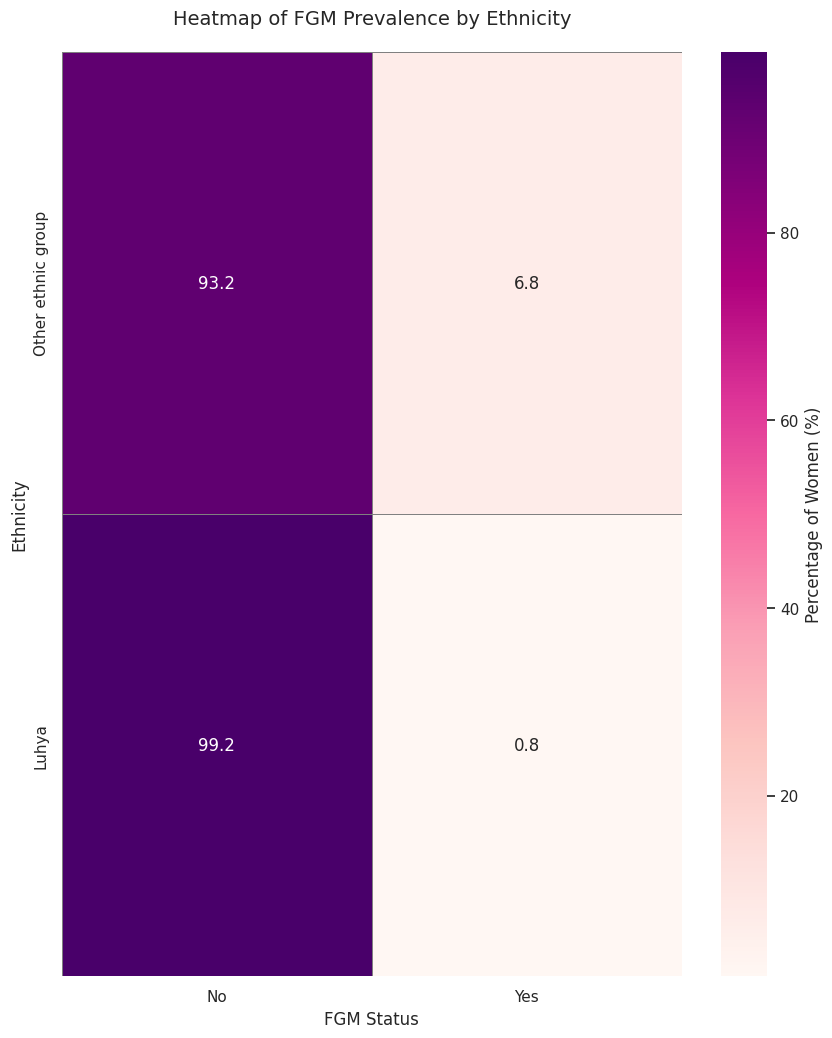

In [6]:
# 7. HEATMAP VISUALIZATION
# Best for: Identifying "Hot Spots" of prevalence without using bars

plt.figure(figsize=(10, 12)) # Taller figure to fit all ethnicities

# Create the percentage table again (just to be safe)
heatmap_data = pd.crosstab(df_clean['Ethnicity'], df_clean['FGM_Status'], normalize='index') * 100

# Sort by 'Yes' percentage so the "High Risk" groups are at the top
yes_col = [col for col in heatmap_data.columns if 'Yes' in str(col) or 'Circumcised' in str(col)][0]
heatmap_data = heatmap_data.sort_values(by=yes_col, ascending=False)

# Draw Heatmap
sns.heatmap(
    heatmap_data,
    annot=True,       # Write the numbers inside the boxes
    fmt=".1f",        # Format as 1 decimal place (e.g., 94.2)
    cmap="RdPu",      # Red-Purple color scheme (White -> Pink -> Dark Purple)
    linewidths=0.5,   # Small lines between boxes
    linecolor='gray',
    cbar_kws={'label': 'Percentage of Women (%)'} # Label the color bar
)

plt.title('Heatmap of FGM Prevalence by Ethnicity', fontsize=14, pad=20)
plt.ylabel('Ethnicity')
plt.xlabel('FGM Status')

# Save
plt.savefig('kenya_heatmap.png')
print("Heatmap saved as 'kenya_heatmap.png'")

plt.show()

Sort order used in graph: ['None', 'Primary', 'Secondary+']

--- FGM Prevalence by Education (%) ---
FGM_Status         No       Yes
Education                      
None        94.444444  5.555556
Primary     98.640777  1.359223
Secondary+  99.363057  0.636943

Chi-Square P-Value (Education): 0.04282754759237658
Graph saved as 'kenya_education_percentage.png'


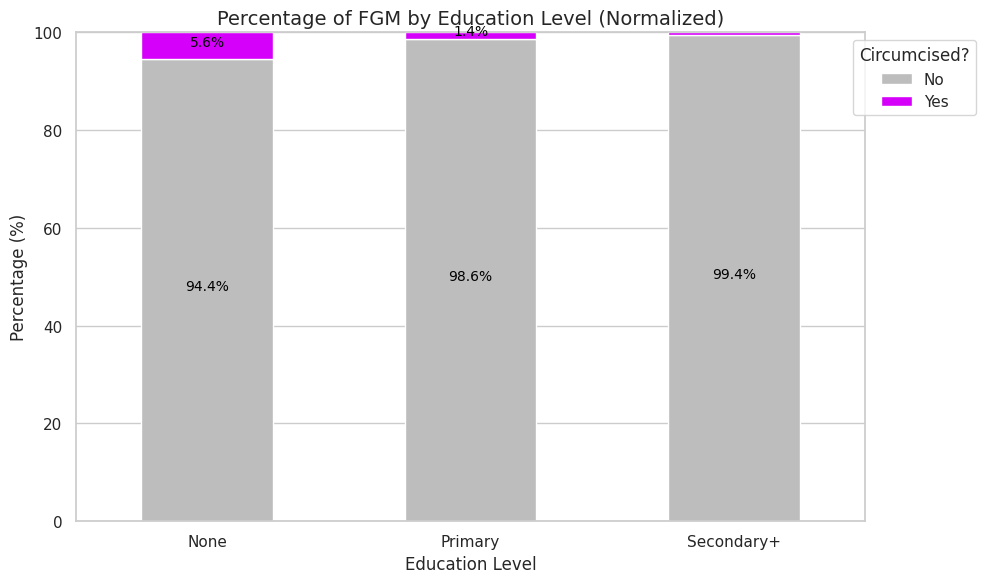

In [7]:
# 7. EDUCATION LEVEL ANALYSIS

# A. Define Logical Order
# We define the order from Lowest to Highest education for the graph
edu_order = ['None', 'Primary', 'Secondary+']

# Filter to ensure we only use labels that actually exist in the dataframe
valid_order = [x for x in edu_order if x in df_clean['Education'].unique()]

print(f"Sort order used in graph: {valid_order}")

# B. Calculate Stats & Percentages
# Normalize='index' ensures each row sums to 100%
edu_pct = pd.crosstab(df_clean['Education'], df_clean['FGM_Status'], normalize='index') * 100

# Reindex the dataframe to match our logical order
edu_pct = edu_pct.reindex(valid_order)

print("\n--- FGM Prevalence by Education (%) ---")
print(edu_pct)

# C. Chi-Square Test
# Run the statistical test to check for significance
chi2_edu, p_edu, _, _ = chi2_contingency(pd.crosstab(df_clean['Education'], df_clean['FGM_Status']))
print(f"\nChi-Square P-Value (Education): {p_edu}")

# D. Visualization (Stacked Bar Chart)
# Pandas built-in plotting is used for stacked bars
ax = edu_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#BDBDBD', '#D500F9'], # Gray (No) - Neon Purple (Yes)
    edgecolor='white' # Adds white lines between segments for clarity
)

# E. Formatting
plt.title('Percentage of FGM by Education Level (Normalized)', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Education Level', fontsize=12)
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(title='Circumcised?', loc='upper right', bbox_to_anchor=(1.15, 1)) # Move legend outside

# F. Add Labels to Bars (Critical for readability)
# We add text labels to show the exact percentage on the bars
for c in ax.containers:
    # Filter to only show labels > 1% to avoid clutter on small bars
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 1.0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color='black', fontsize=10, padding=3)

# Limit Y-axis to 100%
plt.ylim(0, 100)
plt.tight_layout()

# Save image
plt.savefig('kenya_education_percentage.png')
print("Graph saved as 'kenya_education_percentage.png'")

plt.show()

### 5. Conclusion & Resolution: The Drivers of FGM in Kenya

Based on the EDA and statistical testing conducted in this notebook, we have isolated two critical drivers of FGM/C prevalence in Kenya: **Ethnicity** (Cultural Driver) and **Education** (Socio-economic Mitigator).

#### 1. The Primacy of Ethnicity (Culture > Religion)
Our initial hypothesis investigated religious affiliation. However, the data reveals that **Ethnicity** is the dominant confounding variable.
* **Observation:** FGM is not practiced uniformly across any single religion. Instead, it is highly concentrated in specific ethnic groups (e.g., Somali, Kisii, Masai), regardless of whether those groups are predominantly Muslim or Christian.
* **Implication:** Interventions targeting religious leaders alone may be insufficient unless they address specific tribal cultural norms.

#### 2. Education as a Protective Factor
The stacked bar analysis reveals a strong negative correlation between education and FGM prevalence ($p < 0.05$).
* **Observation:** Women with No Education have significantly higher FGM rates (5.6%) compared to those with Secondary/Higher Education (0.6%).
* **Implication:** Education acts as a "social vaccine." As women gain access to higher education, adherence to traditional harmful practices like FGM drops precipitously.

**Final Verdict for Kenya:**
FGM in Kenya is a **culturally specific** practice maintained by ethnic tradition, but effectively **mitigated by formal education**.